# <font color=blus>Table of contents</font>

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1, last_level=4, header="Result issued from biais metrics")

# <font color=blus> Abstract</font>

    This notebook aims to expose bias preformances over CNN model built from notebook CNN_BinaryClassifier.
    
    1) Input data for validation is loaded. This data is issued from DataPreparator notebook.
    
    2) Model issued from CNN_binaryClassifier notebook is loaded and predictions are computed over validation dataset.
    
    3) Bias performance is computed using formula provided into kaggle Jigsaw https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation
    

# <font color=blus> Software engineering</font>
<img src="./img/SoftwareEngineeringBiasMetrics.png">

In [30]:
from sklearn import metrics
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [7]:
import p9_util

TOXICITY_COLUMN = p9_util.COLUMN_NAME_TARGET
TEXT_COLUMN = p9_util.COLUMN_NAME_DOC

# Create a text tokenizer.
#tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
#tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 250
MODEL_NAME='predict'

# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']


# <font color=blus> 1. Loading dataset</font>

Dataset is extracted from ̀`DataPreparator` object configured for validation.

Such object contains 
* parameters used for processing data digitalization that leads to build `DataPreparator` object
* list of files saved on hard-disk for data validation.

See `DataPreparator.ipynb` notebook, for more details.

## <font color='blus'> 1.1 Load `DataPreparator` for validation</font>

In [1]:
import p5_util
filename = "./data/dataPreparator_valid_12000.dill"
if True:
    dataprep = p5_util.object_load(filename)
else :
    p5_util.object_dump(dataprep,filename)
self = dataprep


p5_util.object_load : fileName= ./data/dataPreparator_valid_12000.dill


Using TensorFlow backend.
/home/bangui/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
W1118 11:18:19.376524 140345841567552 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1118 11:18:19.377181 140345841567552 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/adanet/tf_compat/__init__.py:96: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

W1118 11:1

In [2]:
list_df_data_file  = self.list_df_data_file.copy()
del(self)
list_df_data_file

['./data/df_dataprep_matrix_32.dill',
 './data/df_dataprep_matrix_82.dill',
 './data/df_dataprep_matrix_57.dill',
 './data/df_dataprep_matrix_122.dill',
 './data/df_dataprep_matrix_118.dill',
 './data/df_dataprep_matrix_86.dill',
 './data/df_dataprep_matrix_66.dill',
 './data/df_dataprep_matrix_52.dill',
 './data/df_dataprep_matrix_30.dill',
 './data/df_dataprep_matrix_79.dill',
 './data/df_dataprep_matrix_36.dill',
 './data/df_dataprep_matrix_109.dill']

    Once a file is loaded as a dataframe then original index column is added.
    
    This operation allows to join columns from original dataframe with 
    the dataframe columns issued from CNN model computation.
    

In [3]:
import pandas as pd
import p5_util

filename = list_df_data_file[0]
max_row = 20000
start_row = 0
df_data = pd.DataFrame()
for filename in list_df_data_file :
    
    df_data_tmp = p5_util.object_load(filename)
    end_row = start_row +len(df_data)
    
    if end_row > max_row :
        break
    else :
        df_data = pd.concat([df_data,df_data_tmp])
        start_row = end_row
    
df_data.reset_index(inplace=True)
df_data.rename(columns={'index':'original_index'}, inplace=True)
df_data.sample(3)

p5_util.object_load : fileName= ./data/df_dataprep_matrix_32.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_82.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_57.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_122.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_118.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_86.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_66.dill


,original_index,docs,counting,tokens,matrix_padded,target
4976,442064,pathetic.,1,[pathetic],"[[-1.0268000364303589, -0.25707998871803284, 0...",1
3416,1416945,"the problem is, vouchers will do the opposite ...",16,"[problem, voucher, opposite, advocate, provide...","[[-0.1809699982404709, 0.37808001041412354, -0...",0
5395,248332,jjp did pass himself off as a woman for at lea...,7,"[jjp, pass, woman, year, avatar, imbecile, kru...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


    Make data to be compliant for CNN model input layer.

In [4]:
import numpy as np

X = df_data.matrix_padded
print(X.shape)
#-----------------------------------------------------------------------
# Prepare input data in order to feed model prediction function : 
#    * Complete tuple of dimensions, out of 1st dimension.
#    * Compute shape for data feeding predictor.
#    * Initialize array with shape previously computed
#    * Transfer data into input
#-----------------------------------------------------------------------
list_tuple = list()
list_tuple.append(len(X))
for shape in X.iloc[0].shape:
    list_tuple.append(shape)

input_shape = tuple(i for i in list_tuple)
x_input = np.zeros(input_shape)

for item in range(len(X)):
    x_input[item]= X.values[item].copy()
input_model = x_input.copy()

(6000,)


    Save memory

In [5]:
del(x_input)

In [6]:
input_model.shape

(6000, 100, 300)

# <font color='blus'>2. Process to predictions</font>

## <font color='blus'> 2.1. Loading CNN model</font>

In [33]:
import keras

filename_model = './data/benchmark/model_jigsaw_submission_sample129651_threshold0.5_best_save.h5'
model = keras.models.load_model(filename_model)

model.summary()

W1118 11:53:35.874965 139728375486272 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1118 11:53:36.038844 139728375486272 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1118 11:53:36.040052 139728375486272 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1118 11:53:36.064640 139728375486272 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 300)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 100, 300)          1200      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 256)          153856    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 20, 256)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 256)           1024      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 20, 256)           196864    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 256)            0         
__________

## <font color='blus'> 2.2. Apply predictions with CNN model</font>

In [8]:
df_data['predict'] = model.predict(input_model)[:,1]

In [9]:
arr_index = df_data['predict'].sample(5).index
df_data['predict'].loc[arr_index]

379     0.769173
1384    0.005107
5429    0.000253
3404    0.000389
968     0.000296
Name: predict, dtype: float32

## <font color='blus'> 2.3. Save predictions on hardisk</font>

In [10]:
import p5_util
filename = './data/df_data_prediction.dill'
p5_util.object_dump(df_data, filename, is_verbose=True)

object_dump: file name= ./data/df_data_prediction.dill


# <font color='blus'> 3. Load dataframe with predictions from hardisk</font>

In [1]:
import p5_util
filename = './data/df_data_prediction.dill'
df_data = p5_util.object_load(filename, is_verbose=True)

p5_util.object_load : fileName= ./data/df_data_prediction.dill


    Convert them into binary values.

In [18]:
df_data['predict'].loc[arr_index]

5662    0
882     1
1572    1
5730    1
589     0
Name: predict, dtype: int64

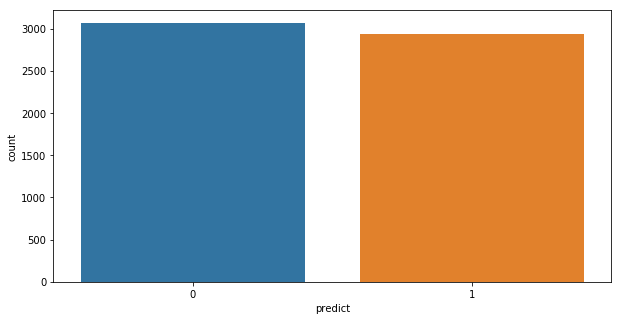

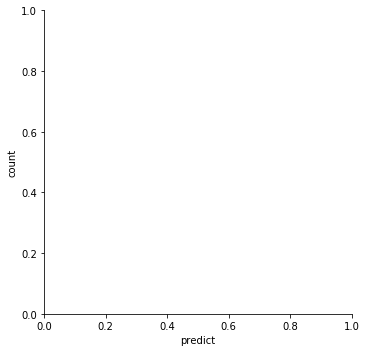

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
_ = sns.catplot(ax=ax, x='predict', data=df_data, kind='count')

## <font color='blus'> 3.1 Load original dataset into df_train dataframe.</font>

For bias computation, informations from original dataset has to be linked with those issued from predicions.

In [10]:
import pandas as pd
import p5_util
df_train = pd.read_csv('./data/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

## <font color='blus'>3.2. Build of df_identity dataframe.</font>

    For bias evaluation, df_identity dataframe is built from original dataframe.
    
    Columns from df_identity dataframe are required.
    
    Due to this, a join process between dataframe issued from CNN computation and df_identity 
    dataframe takes place.

In [11]:
import p9_util_metrics

identity_columns = p9_util_metrics.IDENTITY_COLUMNS

In [12]:
import p9_util

#----------------------------------------------------------------------------
# Filter rows from original dataset with original indexes stored into 
# self.df_data
#----------------------------------------------------------------------------
filtered_index = df_data[p9_util.COLUMN_NAME_INDEX]

#----------------------------------------------------------------------------
# Apply filtered_index indexes over columns of df_indetity dataframe.
#----------------------------------------------------------------------------
df_identity = df_train.loc[filtered_index.values][identity_columns+['target','id']]

#----------------------------------------------------------------------------
# Reset indexes of df_identity dataframe;  new index column is renamed 
# original_index.
#----------------------------------------------------------------------------
df_identity.reset_index(inplace=True)


df_identity.rename(columns={'index':'original_index'}, inplace=True)
print(df_identity.columns)

Index(['original_index', 'male', 'female', 'homosexual_gay_or_lesbian',
       'christian', 'jewish', 'muslim', 'black', 'white',
       'psychiatric_or_mental_illness', 'target', 'id'],
      dtype='object')


    Save memory

In [13]:
del(df_train)

In [14]:
df_identity['target'].sample(10)

178     0.095238
35      0.600000
586     0.600000
3202    0.000000
1445    0.000000
1280    0.000000
614     0.600000
963     0.000000
4523    0.000000
5709    0.000000
Name: target, dtype: float64

    Get 3 randoms rows from df_identity dataframe and let's check corresponding columns values
    do match with original dataset (df_train is the original dataset).
    
    Visual check is applied on columns id values for each dataframe.

In [65]:
arr_index = df_identity.original_index.sample(3).values
df_identity[df_identity['original_index'].isin(arr_index)]

,original_index,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,targettrue_,id,docs,counting,tokens,matrix_padded,target,predict,bin_target,bin_predict
848,1325472,False,False,False,False,False,False,False,False,False,0.000000,5735252,"he'll soon be known as ""ben dover""",4,"[soon, know, ben, dover]","[[0.3000200092792511, -0.04870599880814552, -0...",False,0.000336,0,0
3719,604381,False,False,False,False,False,False,False,False,False,0.514286,981866,"look, dunham sexually molested her little sist...",44,"[look, sexually, molest, little, sister, year,...","[[-0.01946300081908703, -0.18862000107765198, ...",False,0.836297,0,1
4442,414529,False,False,False,False,False,False,False,False,False,0.000000,750515,wrong again. the kingdom infrastructure was ta...,21,"[wrong, kingdom, infrastructure, take, insurge...","[[-0.20095999538898468, 0.37617000937461853, -...",False,0.003966,0,0


    target column from df_identity dataframe is converted as a binary vector with same threshold 
    fixed for CNN model.  
    
    This way, model performance will be measure aagiant df_identity true values.

In [9]:
import numpy as np
if False : 
    df_identity['target'] = np.where(df_identity['target'] >= 0.5, 1, 0)

    Visual check over target column name.

In [66]:
df_identity[df_identity['original_index'].isin(arr_index)]

,original_index,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,targettrue_,id,docs,counting,tokens,matrix_padded,target,predict,bin_target,bin_predict
848,1325472,False,False,False,False,False,False,False,False,False,0.000000,5735252,"he'll soon be known as ""ben dover""",4,"[soon, know, ben, dover]","[[0.3000200092792511, -0.04870599880814552, -0...",False,0.000336,0,0
3719,604381,False,False,False,False,False,False,False,False,False,0.514286,981866,"look, dunham sexually molested her little sist...",44,"[look, sexually, molest, little, sister, year,...","[[-0.01946300081908703, -0.18862000107765198, ...",False,0.836297,0,1
4442,414529,False,False,False,False,False,False,False,False,False,0.000000,750515,wrong again. the kingdom infrastructure was ta...,21,"[wrong, kingdom, infrastructure, take, insurge...","[[-0.20095999538898468, 0.37617000937461853, -...",False,0.003966,0,0


    Note below that true label values in target column are compared with predicted values in predict column.

In [16]:
df_data[df_data['original_index'].isin(arr_index)]

,original_index,docs,counting,tokens,matrix_padded,target,predict
1760,862071,you truly are something else. a downright mean...,5,"[truly, downright, mean, spirited, individual]","[[-0.0008845599950291216, 0.25277000665664673,...",1,0.451386
2365,1011826,@joec:\njust like we didn't hear a global outc...,66,"[@joec, like, hear, global, outcry, christian,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0.241476
5163,505249,you're protesting to the point of idiocy. but ...,3,"[protest, point, idiocy]","[[-0.1667100042104721, -0.2857699990272522, 0....",1,0.971640


    Join dataframe issued from prediction model with identities dataframe issued from original dataframe.
    
    This join operation is based on original_index column.

In [17]:
df_identity = df_identity.join(df_data.set_index('original_index'), on='original_index', lsuffix='true_')

df_identity.columns

Index(['original_index', 'male', 'female', 'homosexual_gay_or_lesbian',
       'christian', 'jewish', 'muslim', 'black', 'white',
       'psychiatric_or_mental_illness', 'targettrue_', 'id', 'docs',
       'counting', 'tokens', 'matrix_padded', 'target', 'predict'],
      dtype='object')

    df_identity dataframe is now assigned with predict column, as shown on display below.
    
    arr_index is indexes array issued from previous sampling.
    
    Method isin(arr_index) allows to filter rows from df_identity that are in arr_index.

In [18]:
df_identity[df_identity['original_index'].isin(arr_index)][['original_index','target','predict']]

,original_index,target,predict
1760,862071,1,0.451386
2365,1011826,0,0.241476
5163,505249,1,0.971640


# <font color='blus'> 4.0 Bias metrics computation</font>

In [57]:
identity = 'male'
df_identity[identity].dropna().sample(3)

4990    0.0
4522    0.1
1356    0.0
Name: male, dtype: float64

In [59]:
import numpy as np
import p9_util_benchmark
threshold = p9_util_benchmark.dict_param_benchmark['threshold']
print(threshold)
if False :
    for identity in identity_columns :
        df_identity[identity] = np.where(df_identity[identity] >= threshold, True, False)

In [24]:
import p9_util_benchmark
df_identity = p9_util_benchmark.convert_dataframe_to_bool(df_identity, \
                                                          dict_param_benchmark_= p9_util_benchmark.dict_param_benchmark)

In [27]:
df_identity[['target',MODEL_NAME]].sample(5)

,target,predict
1946,False,0.001971
3702,True,0.997482
452,True,0.997713
2042,True,0.758967
5479,True,0.799551


In [28]:
import p9_util_metrics
import p9_util_benchmark

MODEL_NAME='predict'
TOXICITY_COLUMN = p9_util_benchmark.TOXICITY_COLUMN
bias_metrics_df = p9_util_metrics.compute_bias_metrics_for_model(df_identity, identity_columns, \
                                                                 MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
6,0.940530,0.738215,black,0.733850,104
2,0.916269,0.826075,homosexual_gay_or_lesbian,0.762745,77
7,0.948426,0.791286,white,0.813370,179
5,0.933537,0.842963,muslim,0.852408,104
1,0.909863,0.905294,female,0.874957,219
0,0.933572,0.895041,male,0.893050,195
8,0.962199,0.823217,psychiatric_or_mental_illness,0.894737,24
3,0.913936,0.922058,christian,0.901708,150
4,0.943368,0.901461,jewish,0.913043,37


In [29]:
overall_auc = p9_util_metrics.calculate_overall_auc(df_identity, MODEL_NAME, p9_util_metrics.TOXICITY_COLUMN)
print("Global AUC = {}".format(overall_auc))

Global AUC = 0.9312528859447909


In [73]:
p9_util_metrics.get_final_metric(bias_metrics_df, overall_auc)

Bias score contribution : 0.6508349364338419


0.8836481579200397

In [74]:
bias_metrics_df.columns

Index(['bnsp_auc', 'bpsn_auc', 'subgroup', 'subgroup_auc', 'subgroup_size'], dtype='object')

In [76]:
bias_metrics_df_corr = bias_metrics_df[['bnsp_auc', 'bpsn_auc', 'subgroup_auc']].corr()

In [78]:
bias_metrics_df_corr

,bnsp_auc,bpsn_auc,subgroup_auc
bnsp_auc,1.000000,-0.492924,0.049593
bpsn_auc,-0.492924,1.000000,0.825670
subgroup_auc,0.049593,0.825670,1.000000


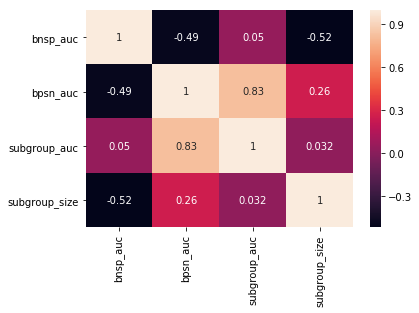

In [81]:
import seaborn as sns
_=sns.heatmap(bias_metrics_df.corr(), annot=True)

# <font color='blus'> 5.0 Binary classification performances</font>

**If memory resources are too weak due to previous steps, the restart kernel and execute cell below.**

In [31]:
df_identity.columns

Index(['original_index', 'male', 'female', 'homosexual_gay_or_lesbian',
       'christian', 'jewish', 'muslim', 'black', 'white',
       'psychiatric_or_mental_illness', 'targettrue_', 'id', 'docs',
       'counting', 'tokens', 'matrix_padded', 'target', 'predict'],
      dtype='object')

In [37]:
import p9_util_benchmark
threshold = p9_util_benchmark.dict_param_benchmark['threshold']

df_identity['bin_predict'] = np.where(df_identity['predict'] >= threshold, 1, 0)

In [64]:
df_identity[['target','predict']].sample(5)

,target,predict
4917,False,0.001367
2821,True,0.758281
2247,False,0.012666
216,True,0.882552
1312,False,0.001180


Normalized confusion matrix
[[0.85805831 0.14194169]
 [0.13476902 0.86523098]]


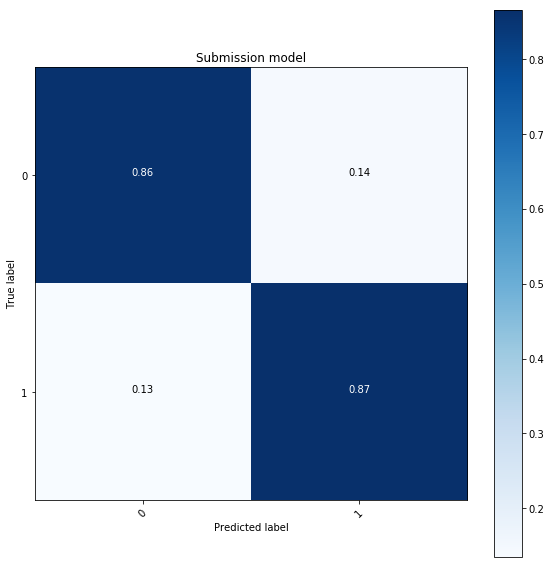

In [68]:
import matplotlib.pyplot as plt
from  sklearn import metrics 
import p4_util

list_classes = [label for label in range(0,2)]
# confusion_matrix
title="Submission model"
cm = metrics.confusion_matrix(df_identity.target, df_identity.bin_predict)
p4_util.plot_confusion_matrix(cm, list_classes,
                          normalize=True,
                          title=title,
                          cmap=plt.cm.Blues)
if False :
    p4_util.plot_confusion_matrix(cm, list_classes,
                              normalize=False,
                              title=title,
                              cmap=plt.cm.Blues)


AUC = 0.9312528859447909


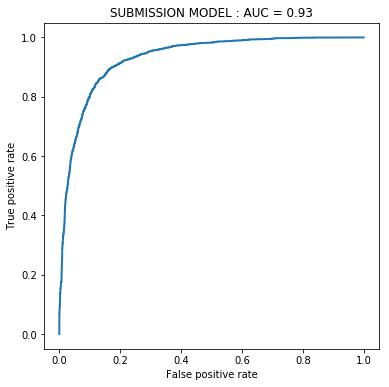

In [70]:
from  sklearn import metrics 

fpr, tpr, thr = metrics.roc_curve(df_identity.target, df_identity.predict)
auc = metrics.roc_auc_score(df_identity.target, df_identity.predict)
print("AUC = {}".format(auc))
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC
plt.plot(fpr, tpr, '-', lw=2, label='11 classes AUC=%.2f' % auc)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("SUBMISSION MODEL : AUC = {}".format(np.round(auc,2)))
plt.show()